In [78]:
#### IMPORTS
import os

import importlib, pkg_resources
importlib.reload(pkg_resources)

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

from cirq.contrib.svg import SVGCircuit
%matplotlib inline

# test

In [97]:

print("before", tf.keras.backend.floatx())
tf.keras.backend.set_floatx('float64')
tf.keras.backend.floatx()

before float64


'float64'

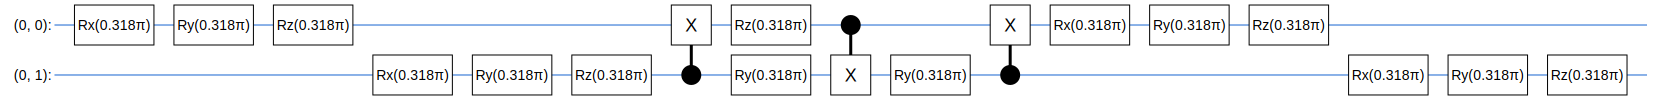

In [511]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.rx(symbols[0])(bit),
        cirq.ry(symbols[1])(bit),
        cirq.rz(symbols[2])(bit))


# https://arxiv.org/pdf/quant-ph/0308006.pdf
def two_qubit_unitary(bits, symbols, full=False):
    """Make a Cirq circuit that creates a non arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    if full:
        circuit += one_qubit_unitary(bits[0], symbols[0:3])
        circuit += one_qubit_unitary(bits[1], symbols[3:6])
    
    
    #circuit += cirq.rz(-np.pi/2.)(bits[1])
        
    circuit += cirq.CNOT(bits[1],bits[0])
    
    circuit += cirq.rz(symbols[0+6*full])(bits[0])
    circuit += cirq.ry(symbols[1+6*full])(bits[1])  
    
    circuit += cirq.CNOT(bits[0],bits[1])
    
    circuit += cirq.ry(symbols[2+6*full])(bits[1]) 
    
    circuit += cirq.CNOT(bits[1],bits[0])
        
    #circuit += cirq.rz(np.pi/2.)(bits[0]) 
    
    
    #circuit += [cirq.ZZ(*bits)**symbols[6]]   They want to replicate this
    #circuit += [cirq.YY(*bits)**symbols[7]]
    #circuit += [cirq.XX(*bits)**symbols[8]]
    if full:   
        circuit += one_qubit_unitary(bits[0], symbols[9:12])
        circuit += one_qubit_unitary(bits[1], symbols[12:15])
        
    return circuit

bits = cirq.GridQubit.rect(1,2)
SVGCircuit(two_qubit_unitary(bits, np.ones(16), full=True))

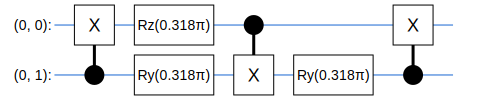

In [83]:
bits = cirq.GridQubit.rect(1,2)
SVGCircuit(two_qubit_unitary(bits, np.ones(16), full=False))

In [138]:
# Example circuit simple
# Count number of excitations (1), if number of excitations > half qbits, show 1, else 0

# to pass data as initial state we must construc it. So we need to give the cirucit. It's just X gate. X^{num} = X^{n0}X^{n1}...


def generate_data(qubits):
    test = []
    label = []
    
    n = len(qubits)
    for i in range(2**n):
        b = bin(i)[2:]
        b = '0'*(n-len(b)) + b
        count = 0
        for c in b:
            if c == '1':
                count+=1
            
        label.append(-1 if count > n/2 else +1)
        test.append(cirq.Circuit( (cirq.X(qubits[l]) for l in range(len(b)) if b[l]=='1')))
        
    return tfq.convert_to_tensor(test), np.array(label)

qubits = cirq.GridQubit.rect(1,5)

test, label = generate_data(qubits)



In [8]:
bits = cirq.GridQubit.rect(1,5)
cirq.Circuit(cirq.X(bits[0]), cirq.X(bits[0])) + cirq.Circuit(cirq.X(bits[1]))

(0, 0): ───X───X───────

(0, 1): ───────────X───

In [501]:
def quantum_circuit(op_bits, readout_bit, parameters, full=False):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    
    #obs = np.prod([Z(4n)])
    #obs = SymbolicHamiltonian(obs, backend=backend)
    
    for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[0:3])
        
    """for bit, bitn in zip(op_bits[:-1], op_bits[1:]):
        circuit += two_qubit_unitary([bit, bitn], parameters[6+12*full:9+12*full], full=False)
        
    circuit += two_qubit_unitary([op_bits[-1], op_bits[0]], parameters[3:6], full=False)"""
        
    for bit in op_bits:
        circuit += two_qubit_unitary([bit, readout_bit], parameters[3:6+12*full], full=full)
        
    """for bit, bitn in zip(op_bits[:-1], op_bits[1:]):
        circuit += two_qubit_unitary([bit, bitn], parameters[9+12*full:12+12*full], full=False)
        
    circuit += two_qubit_unitary([op_bits[-1], op_bits[0]], parameters[9+12*full:12+12*full], full=False)"""
        
    
    
    
    """for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[6:9])
        
    for bit in op_bits:
        circuit += two_qubit_unitary([bit, readout_bit], parameters[9:12], full=False)
        
        
    
    
    for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[12:15])
    
    for bit in op_bits:
        circuit += two_qubit_unitary([bit, readout_bit], parameters[15:18], full=False)"""
        
    
    
    
        
    #for bit in op_bits:
    #    circuit += two_qubit_unitary([bit, readout_bit], parameters[3:], full=full)
        
    
    return circuit

param = sympy.symbols('p:48')


n = 4


qubits = cirq.GridQubit.rect(1,n)
readoutqubit = cirq.GridQubit(-1,-1)

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
input_layer = tfq.layers.AddCircuit()(
    excitation_input, prepend=cirq.Circuit())

readout_operators = cirq.Z(readoutqubit)

quantum_model_circuit = quantum_circuit(qubits, readoutqubit, param, full=False)



# CUSTOMIZE
quantum_modelPQC = tfq.layers.PQC(quantum_model_circuit,
                                  readout_operators, 
                                  initializer=tf.keras.initializers.Constant(value=1.0),
                                  differentiator=tfq.differentiators.ParameterShift())
                                  #backend=cirq.Simulator())
                                     
    
                                    ## Differentiators
                                  #differentiator=tfq.differentiators.ParameterShift(),
                                    
                                    ## Sampling
                                    #repetitions=None)
                    
                                    ## Initializer (parameters)
                                    #tf.keras.initializers.RandomUniform(0, 2 * np.pi)
                                    #tf.keras.initializers.Constant(value=1.0)
                                
                                  #initializer=tf.keras.initializers.RandomUniform(0, 2 * np.pi))
                                  #repetitions=10) # None: state vector expectation / Number: Sampling

qm = quantum_modelPQC
                                
quantum_model = quantum_modelPQC(input_layer)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])



SVGCircuit(
    quantum_model_circuit)#sympy.symbols('x0:15')))

ValueError: Arithmetic expression outside of simple scalar multiplication is currently not supported. See serializer.py for more information.

In [90]:
# Breaks with float 64???

@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

In [181]:
inputs, labels = generate_data(qubits)


ninp = len(inputs)
split = int(ninp*1)

train_excitations = inputs[:split]
train_labels = labels[:split]

test_excitations = inputs[split:]
test_labels = labels[split:]

#tf.keras.optimizers.Adam(learning_rate=0.02)
#tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
#tf.keras.optimizers.Adam(learning_rate=0.02)  # Adams                   # Default parameters, but made explicit. Basic gradient descent
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse)#,
                   #metrics=[custom_accuracy])
    
print(qcnn_model.get_weights())

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=1,
                         epochs=100,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

[array([1., 1., 1., 1., 1., 1.], dtype=float32)]
Epoch 1/100
16/16 [==============================] - 1s 32ms/step - loss: 1.0031
Epoch 2/100
16/16 [==============================] - 0s 30ms/step - loss: 0.9175
Epoch 3/100
16/16 [==============================] - 0s 28ms/step - loss: 0.8946
Epoch 4/100
16/16 [==============================] - 0s 28ms/step - loss: 0.9009
Epoch 5/100
16/16 [==============================] - 0s 27ms/step - loss: 0.8833
Epoch 6/100
16/16 [==============================] - 0s 28ms/step - loss: 0.8649
Epoch 7/100
16/16 [==============================] - 0s 31ms/step - loss: 0.8516
Epoch 8/100
16/16 [==============================] - 0s 30ms/step - loss: 0.8262
Epoch 9/100
16/16 [==============================] - 0s 27ms/step - loss: 0.8113
Epoch 10/100
16/16 [==============================] - 0s 27ms/step - loss: 0.7910
Epoch 11/100
16/16 [==============================] - 0s 28ms/step - loss: 0.7698
Epoch 12/100
16/16 [==============================] - 0s 2

16/16 [==============================] - 0s 27ms/step - loss: 0.7221


KeyError: 'val_loss'

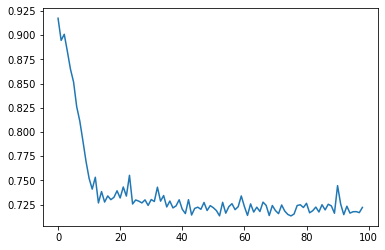

In [183]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [567]:
print(*tuple("{:20} =? {:3}   --->   {:5}".format(x[0], train_labels[i], abs(train_labels[i]-x[0])<1)  for i,x in enumerate(qcnn_model.predict(train_excitations))), sep='\n')


qcnn_model.trainable_variables

 0.05134811997413635 =?   1   --->       1
-0.22285966575145721 =?   1   --->       0
-0.22692462801933289 =?   1   --->       0
-0.03146733343601227 =?   1   --->       0
0.014224156737327576 =?   1   --->       1
-0.08988440781831741 =?   1   --->       0
 -0.0807948037981987 =?   1   --->       0
 0.03189695626497269 =?  -1   --->       0
 0.46371498703956604 =?   1   --->       1
 -0.2625795304775238 =?   1   --->       0
 -0.2849717140197754 =?   1   --->       0
 0.23775608837604523 =?  -1   --->       0
 0.41558054089546204 =?   1   --->       1
 -0.1411268711090088 =?  -1   --->       1
-0.11158232390880585 =?  -1   --->       1
 0.15126290917396545 =?  -1   --->       0


[<tf.Variable 'parameters:0' shape=(24,) dtype=float32, numpy=
 array([0.9316327, 1.6815913, 1.0111773, 2.1699822, 3.8568354, 6.1286526,
        3.102644 , 1.5660274, 2.7262068, 1.72624  , 4.1483912, 4.511825 ,
        3.2235281, 3.1371534, 3.6869867, 5.4236717, 4.194628 , 5.3430223,
        1.7805375, 5.125231 , 3.3614523, 3.445503 , 4.930834 , 6.0574546],
       dtype=float32)>]

####  Manual Training

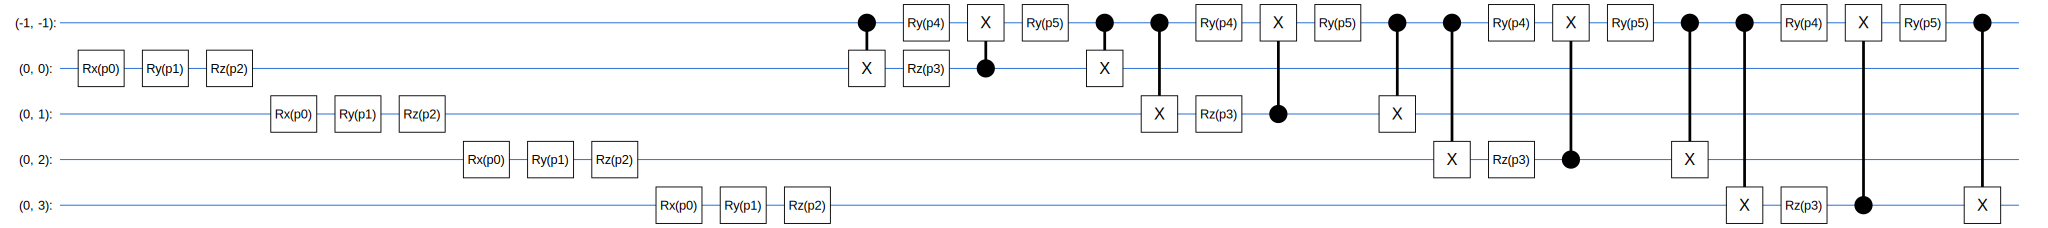

In [545]:
def generate_data_p(qubits):
    test = []
    label = []
    
    n = len(qubits)
    for i in range(2**n):
        b = bin(i)[2:]
        b = '0'*(n-len(b)) + b
        count = 0
        for c in b:
            if c == '1':
                count+=1
        #b = b[::-1]
            
        label.append(-1 if count %2 == 1 else +1)
        test.append(cirq.Circuit( (cirq.X(qubits[l]) for l in range(len(b)) if b[l]=='1')))
        """print(b)
        print(test[-1])"""
    return tfq.convert_to_tensor(test), np.array(label)

def quantum_circuit(op_bits, readout_bit, parameters, full=False, cnot=True, extra=False, depth=1):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    
    #obs = np.prod([Z(4n)])
    #obs = SymbolicHamiltonian(obs, backend=backend)
    
    if cnot:
        for bit in op_bits:
            circuit += cirq.CNOT(bit, readout_bit)
            
    for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[0:3])
    
    for dd in range(depth):
        for bit in op_bits:
            circuit += two_qubit_unitary([bit, readout_bit], parameters[3*(dd*(1+4*full)+1):3*(dd*(1+4*full)+2+4*full)], full=full)
    
    if extra:
        circuit += one_qubit_unitary(readout_bit, parameters[-3:])
    
    """for bit, bitn in zip(op_bits[:-2], op_bits[1:]):
        circuit += two_qubit_unitary([bit, bitn], parameters[6:9], full=False)
        
    circuit += two_qubit_unitary([op_bits[-1], op_bits[0]], parameters[12:15], full=False)
    
    for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[15:18])
    for bit in op_bits:
        circuit += two_qubit_unitary([bit, readout_bit], parameters[18:21], full=False)"""
    
    return circuit

param = sympy.symbols('p:60')


n = 4

def setup(n, param, full=False, extra=False, cnot=True, depth=1):
    qubits = cirq.GridQubit.rect(1,n)
    readoutqubit = cirq.GridQubit(-1,-1)

    excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
    input_layer = tfq.layers.AddCircuit()(
        excitation_input, prepend=cirq.Circuit())
    readout_operators = cirq.Z(readoutqubit)
    quantum_model_circuit = quantum_circuit(qubits, readoutqubit, param, full=full, extra=extra, cnot=cnot, depth=depth)



    # CUSTOMIZE
    quantum_modelPQC = tfq.layers.PQC(quantum_model_circuit,
                                      readout_operators, 
                                      initializer=tf.keras.initializers.Constant(value=1.0))#RandomUniform(0,2*np.pi))#Constant(value=1.0))

    qm = quantum_modelPQC
    quantum_model = quantum_modelPQC(input_layer)
    qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])
    model = qcnn_model
    
    return model, quantum_model_circuit, qubits, readoutqubit
model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, cnot=False, full=False, extra=False)

SVGCircuit(quantum_model_circuit)

In [430]:
def train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=100):
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))


        with tf.GradientTape() as tape:
            logits = model(train_excitations, training=True)  # Logits for this minibatch

            loss_value = tf.math.reduce_mean(loss_fn(train_labels, tf.squeeze(logits)))

        grads = tape.gradient(loss_value, model.trainable_weights)

        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        loss_list.append(loss_value)
        print(
            "Training loss at epoch %d: %.4f"
            % (epoch, float(loss_value)) )#, tf.squeeze(grads)
        
        

def trainStoch(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=100):
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        
        loss_value = 0
        for it in range(len(train_excitations)):
            with tf.GradientTape() as tape:
                logits = model(train_excitations[it:it+1], training=True)  # Logits for this minibatch

                loss_value += tf.math.reduce_mean(loss_fn(train_labels[it:it+1], tf.squeeze(logits)))

            grads = tape.gradient(loss_value, model.trainable_weights)

            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        loss_list.append(loss_value)
        print(
            "Training loss at epoch %d: %.4f"
            % (epoch, float(loss_value)) )#, tf.squeeze(grads)

In [578]:
N = 4
loss = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01*16, momentum=0.0, nesterov=False)
loss_fn = tf.losses.mse

model, quantum_model_circuit, qubits, readoutqubit = setup(N, param, extra=False, full=False, cnot=True, depth=1)
inputs, labels = generate_data_p(qubits)

ninp = len(inputs)
split = int(ninp*1)

train_excitations = inputs[:split]
train_labels = labels[:split]
#train_labels = tf.cast(train_labels, dtype=tf.float64)

test_excitations = inputs[split:]
test_labels = labels[split:]



print(model.weights)


"""batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((train_excitations, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)"""


loss_list = []

epochs = 100
train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=epochs)



[<tf.Variable 'parameters:0' shape=(6,) dtype=float32, numpy=array([1., 1., 1., 1., 1., 1.], dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 0.6292

Start of epoch 1
Training loss at epoch 1: 0.2683

Start of epoch 2
Training loss at epoch 2: 0.0571

Start of epoch 3
Training loss at epoch 3: 0.0193

Start of epoch 4
Training loss at epoch 4: 0.0097

Start of epoch 5
Training loss at epoch 5: 0.0059

Start of epoch 6
Training loss at epoch 6: 0.0039

Start of epoch 7
Training loss at epoch 7: 0.0028

Start of epoch 8
Training loss at epoch 8: 0.0021

Start of epoch 9
Training loss at epoch 9: 0.0017

Start of epoch 10
Training loss at epoch 10: 0.0014

Start of epoch 11
Training loss at epoch 11: 0.0011

Start of epoch 12
Training loss at epoch 12: 0.0009

Start of epoch 13
Training loss at epoch 13: 0.0008

Start of epoch 14
Training loss at epoch 14: 0.0007

Start of epoch 15
Training loss at epoch 15: 0.0006

Start of epoch 16
Training loss at epoch 16: 0.0005

Start of

[array([1.0028266, 1.0103403, 1.0063425, 1.0131096, 1.5484614, 1.5353036],
      dtype=float32)]


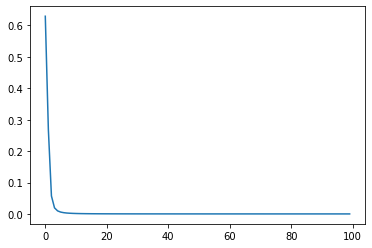

In [579]:
print(model.get_weights())
plt.plot(loss_list)


In [367]:
lossQibo = [0.8134540832112808, 0.8004845937249053, 0.7901812498055115, 0.7819870147510053, 0.7752587399759246, 0.7695522037850754, 0.7646230684685612, 0.7603432877852007, 0.756635901099241, 0.7534420509637819, 0.750708179834802, 0.748382510650672, 0.746414989495453, 0.7447581684102412, 0.7433680880025803, 0.7422048789841038, 0.7412330506899176, 0.7404215167552599, 0.7397434266533349, 0.7391758677925437, 0.7386994919701643, 0.7382981079198171, 0.7379582705109862, 0.7376688875587532, 0.7374208573773592, 0.7372067441370928, 0.7370204936115126, 0.7368571888083588, 0.7367128430051665, 0.7365842266002967, 0.7364687237051988, 0.736364214344357, 0.7362689783376, 0.7361816172976794, 0.7361009916017273, 0.7360261696339826, 0.7359563870158335, 0.7358910139196445, 0.7358295288971546, 0.735771497939924, 0.7357165577307939, 0.7356644022458887, 0.735614772031505, 0.7355674456145271, 0.7355222326137257, 0.7354789682068363, 0.735437508678535, 0.735397727830555, 0.7353595140799772, 0.7353227681073529, 0.7352874009446607, 0.735253332415619, 0.7352204898587245, 0.7351888070775807, 0.735158223474331, 0.7351286833309401, 0.7351001352101635, 0.7350725314536736, 0.7350458277593005, 0.7350199828228978, 0.7349949580331908, 0.7349707172102277, 0.7349472263798533, 0.7349244535780843, 0.7349023686803988, 0.7348809432519077, 0.734860150415093, 0.7348399647324189, 0.7348203621015847, 0.734801319661602, 0.7347828157081698, 0.7347648296170929, 0.7347473417746969, 0.7347303335143556, 0.7347137870583897, 0.734697685464714, 0.7346820125776982, 0.7346667529827832, 0.7346518919644689, 0.7346374154673316, 0.7346233100597783, 0.7346095629002857, 0.7345961617058994, 0.7345830947227975, 0.7345703506987417, 0.7345579188572674, 0.7345457888734687, 0.7345339508512595, 0.7345223953019978, 0.7345111131243727, 0.7345000955854646, 0.7344893343028962, 0.7344788212279977, 0.7344685486299178, 0.734458509080621, 0.7344486954407062, 0.7344391008460024, 0.7344297186948858, 0.7344205426362757, 0.7344115665582648, 0.7344027845773506, 0.7343941910282258, 0.7343857804540964, 0.7343775475974983, 0.7343694873915794, 0.7343615949518238, 0.7343538655681909, 0.7343462946976443, 0.7343388779570539, 0.7343316111164415, 0.7343244900925618, 0.7343175109427892, 0.7343106698593005, 0.7343039631635386, 0.7342973873009342, 0.7342909388358814, 0.734284614446944, 0.7342784109222913, 0.7342723251553381, 0.7342663541405933, 0.734260494969689, 0.7342547448276008, 0.7342491009890294, 0.7342435608149492, 0.7342381217493126, 0.7342327813158949, 0.7342275371152847, 0.7342223868220015, 0.7342173281817411, 0.7342123590087404, 0.7342074771832533, 0.7342026806491397, 0.7341979674115516, 0.73419333553472, 0.7341887831398349, 0.7341843084030135, 0.7341799095533525, 0.7341755848710622, 0.7341713326856755, 0.7341671513743323, 0.734163039360132, 0.7341589951105534, 0.7341550171359377, 0.7341511039880315, 0.7341472542585907, 0.734143466578036, 0.7341397396141618, 0.7341360720708988, 0.7341324626871203, 0.7341289102354984, 0.7341254135214008, 0.7341219713818334, 0.7341185826844195, 0.7341152463264203, 0.7341119612337917, 0.7341087263602746, 0.7341055406865211, 0.7341024032192531, 0.7340993129904505, 0.7340962690565687, 0.7340932704977879, 0.7340903164172852, 0.7340874059405373, 0.7340845382146428, 0.7340817124076755, 0.7340789277080543, 0.7340761833239388, 0.7340734784826453, 0.7340708124300837, 0.734068184430212, 0.7340655937645125, 0.7340630397314841, 0.7340605216461519, 0.7340580388395939, 0.7340555906584855, 0.7340531764646553, 0.7340507956346595, 0.7340484475593682, 0.7340461316435668, 0.7340438473055706, 0.73404159397685, 0.7340393711016703, 0.734037178136742, 0.7340350145508828, 0.7340328798246902, 0.7340307734502247, 0.7340286949307028, 0.7340266437802008, 0.7340246195233662, 0.7340226216951391, 0.7340206498404831, 0.7340187035141237, 0.7340167822802925, 0.734014885712485, 0.7340130133932193, 0.7340111649138077, 0.734009339874131, 0.7340075378824209, 0.734005758555052, 0.734004001516334]

#print(loss_list)

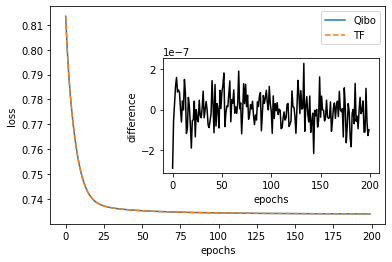

In [446]:
#plt.plot(np.abs(np.array(loss_list)-np.array(lossQibo)))

fig, ax1 = plt.subplots()

plt.xlabel("epochs")
plt.ylabel("loss")

left, bottom, width, height = [0.385, 0.3, 0.5, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(loss_list[:200], label='Qibo')
ax1.plot(lossQibo[:200], '--', label='TF')

ax2.plot(np.array(loss_list)-np.array(lossQibo), 'k')

ax1.legend()

plt.xlabel("epochs")
plt.ylabel("difference")
plt.savefig("compare.pdf")


In [436]:
#qcnn_model.predict(train_excitations)

N = 6

lossp = []
loss = []

losspF = []
lossF = []

lossp_ = []
loss_ = []

losspF_ = []
lossF_ = []

loss_fn = tf.losses.mse

#optimizer=tf.keras.optimizers.SGD(learning_rate=0.01*16, momentum=0.0, nesterov=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    
for n in range(1,N+1):
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=True, cnot=True)
    inputs, labels = generate_data(qubits)

    ninp = len(inputs)
    split = int(ninp*1)

    train_excitations = inputs[:split]
    train_labels = labels[:split]
    #train_labels = tf.cast(train_labels, dtype=tf.float64)

    test_excitations = inputs[split:]
    test_labels = labels[split:]

    print(model.weights)

    

    """batch_size = 16
    train_dataset = tf.data.Dataset.from_tensor_slices((train_excitations, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)"""

    
    loss_list = []

    epochs = 75
    train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=epochs)
    
    loss.append(loss_list)
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=True, cnot=True)
    inputs, labels = generate_data_p(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    lossp.append(loss_list)
    
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=False, cnot=True)
    inputs, labels = generate_data_p(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    losspF.append(loss_list)
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=False, cnot=True)
    inputs, labels = generate_data(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    lossF.append(loss_list)
    
    
    
    
    loss_list = []

    
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=True, cnot=False)
    train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=epochs)
    
    loss_.append(loss_list)
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=True, cnot=False)
    inputs, labels = generate_data_p(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    lossp_.append(loss_list)
    
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=False, cnot=False)
    inputs, labels = generate_data_p(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    losspF_.append(loss_list)
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=False, cnot=False)
    inputs, labels = generate_data(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    lossF_.append(loss_list)
    
    

[<tf.Variable 'parameters:0' shape=(18,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 2.5205

Start of epoch 1
Training loss at epoch 1: 2.3512

Start of epoch 2
Training loss at epoch 2: 2.1767

Start of epoch 3
Training loss at epoch 3: 1.9995

Start of epoch 4
Training loss at epoch 4: 1.8219

Start of epoch 5
Training loss at epoch 5: 1.6464

Start of epoch 6
Training loss at epoch 6: 1.4754

Start of epoch 7
Training loss at epoch 7: 1.3112

Start of epoch 8
Training loss at epoch 8: 1.1559

Start of epoch 9
Training loss at epoch 9: 1.0112

Start of epoch 10
Training loss at epoch 10: 0.8787

Start of epoch 11
Training loss at epoch 11: 0.7592

Start of epoch 12
Training loss at epoch 12: 0.6530

Start of epoch 13
Training loss at epoch 13: 0.5602

Start of epoch 14
Training loss at epoch 14: 0.4799

Start of epoch 15
Training loss at epoch 15: 0.4113

Star

Training loss at epoch 12: 0.3589

Start of epoch 13
Training loss at epoch 13: 0.2517

Start of epoch 14
Training loss at epoch 14: 0.1702

Start of epoch 15
Training loss at epoch 15: 0.1110

Start of epoch 16
Training loss at epoch 16: 0.0698

Start of epoch 17
Training loss at epoch 17: 0.0423

Start of epoch 18
Training loss at epoch 18: 0.0247

Start of epoch 19
Training loss at epoch 19: 0.0139

Start of epoch 20
Training loss at epoch 20: 0.0075

Start of epoch 21
Training loss at epoch 21: 0.0039

Start of epoch 22
Training loss at epoch 22: 0.0019

Start of epoch 23
Training loss at epoch 23: 0.0009

Start of epoch 24
Training loss at epoch 24: 0.0004

Start of epoch 25
Training loss at epoch 25: 0.0002

Start of epoch 26
Training loss at epoch 26: 0.0001

Start of epoch 27
Training loss at epoch 27: 0.0000

Start of epoch 28
Training loss at epoch 28: 0.0000

Start of epoch 29
Training loss at epoch 29: 0.0000

Start of epoch 30
Training loss at epoch 30: 0.0000

Start of ep

Training loss at epoch 18: 0.0054

Start of epoch 19
Training loss at epoch 19: 0.0039

Start of epoch 20
Training loss at epoch 20: 0.0029

Start of epoch 21
Training loss at epoch 21: 0.0022

Start of epoch 22
Training loss at epoch 22: 0.0018

Start of epoch 23
Training loss at epoch 23: 0.0016

Start of epoch 24
Training loss at epoch 24: 0.0016

Start of epoch 25
Training loss at epoch 25: 0.0016

Start of epoch 26
Training loss at epoch 26: 0.0017

Start of epoch 27
Training loss at epoch 27: 0.0019

Start of epoch 28
Training loss at epoch 28: 0.0021

Start of epoch 29
Training loss at epoch 29: 0.0023

Start of epoch 30
Training loss at epoch 30: 0.0025

Start of epoch 31
Training loss at epoch 31: 0.0026

Start of epoch 32
Training loss at epoch 32: 0.0027

Start of epoch 33
Training loss at epoch 33: 0.0027

Start of epoch 34
Training loss at epoch 34: 0.0026

Start of epoch 35
Training loss at epoch 35: 0.0025

Start of epoch 36
Training loss at epoch 36: 0.0024

Start of ep

Training loss at epoch 28: 0.0185

Start of epoch 29
Training loss at epoch 29: 0.0195

Start of epoch 30
Training loss at epoch 30: 0.0198

Start of epoch 31
Training loss at epoch 31: 0.0196

Start of epoch 32
Training loss at epoch 32: 0.0189

Start of epoch 33
Training loss at epoch 33: 0.0178

Start of epoch 34
Training loss at epoch 34: 0.0164

Start of epoch 35
Training loss at epoch 35: 0.0149

Start of epoch 36
Training loss at epoch 36: 0.0133

Start of epoch 37
Training loss at epoch 37: 0.0117

Start of epoch 38
Training loss at epoch 38: 0.0102

Start of epoch 39
Training loss at epoch 39: 0.0088

Start of epoch 40
Training loss at epoch 40: 0.0075

Start of epoch 41
Training loss at epoch 41: 0.0064

Start of epoch 42
Training loss at epoch 42: 0.0054

Start of epoch 43
Training loss at epoch 43: 0.0046

Start of epoch 44
Training loss at epoch 44: 0.0039

Start of epoch 45
Training loss at epoch 45: 0.0032

Start of epoch 46
Training loss at epoch 46: 0.0027

Start of ep

Training loss at epoch 36: 0.1046

Start of epoch 37
Training loss at epoch 37: 0.1011

Start of epoch 38
Training loss at epoch 38: 0.0985

Start of epoch 39
Training loss at epoch 39: 0.0966

Start of epoch 40
Training loss at epoch 40: 0.0953

Start of epoch 41
Training loss at epoch 41: 0.0945

Start of epoch 42
Training loss at epoch 42: 0.0940

Start of epoch 43
Training loss at epoch 43: 0.0937

Start of epoch 44
Training loss at epoch 44: 0.0934

Start of epoch 45
Training loss at epoch 45: 0.0930

Start of epoch 46
Training loss at epoch 46: 0.0924

Start of epoch 47
Training loss at epoch 47: 0.0917

Start of epoch 48
Training loss at epoch 48: 0.0908

Start of epoch 49
Training loss at epoch 49: 0.0899

Start of epoch 50
Training loss at epoch 50: 0.0890

Start of epoch 51
Training loss at epoch 51: 0.0881

Start of epoch 52
Training loss at epoch 52: 0.0874

Start of epoch 53
Training loss at epoch 53: 0.0870

Start of epoch 54
Training loss at epoch 54: 0.0868

Start of ep

Training loss at epoch 46: 0.0000

Start of epoch 47
Training loss at epoch 47: 0.0000

Start of epoch 48
Training loss at epoch 48: 0.0000

Start of epoch 49
Training loss at epoch 49: 0.0000

Start of epoch 50
Training loss at epoch 50: 0.0000

Start of epoch 51
Training loss at epoch 51: 0.0000

Start of epoch 52
Training loss at epoch 52: 0.0000

Start of epoch 53
Training loss at epoch 53: 0.0000

Start of epoch 54
Training loss at epoch 54: 0.0000

Start of epoch 55
Training loss at epoch 55: 0.0000

Start of epoch 56
Training loss at epoch 56: 0.0000

Start of epoch 57
Training loss at epoch 57: 0.0000

Start of epoch 58
Training loss at epoch 58: 0.0000

Start of epoch 59
Training loss at epoch 59: 0.0000

Start of epoch 60
Training loss at epoch 60: 0.0000

Start of epoch 61
Training loss at epoch 61: 0.0000

Start of epoch 62
Training loss at epoch 62: 0.0000

Start of epoch 63
Training loss at epoch 63: 0.0000

Start of epoch 64
Training loss at epoch 64: 0.0000

Start of ep

Training loss at epoch 55: 0.0889

Start of epoch 56
Training loss at epoch 56: 0.0899

Start of epoch 57
Training loss at epoch 57: 0.0907

Start of epoch 58
Training loss at epoch 58: 0.0904

Start of epoch 59
Training loss at epoch 59: 0.0893

Start of epoch 60
Training loss at epoch 60: 0.0881

Start of epoch 61
Training loss at epoch 61: 0.0875

Start of epoch 62
Training loss at epoch 62: 0.0877

Start of epoch 63
Training loss at epoch 63: 0.0883

Start of epoch 64
Training loss at epoch 64: 0.0886

Start of epoch 65
Training loss at epoch 65: 0.0884

Start of epoch 66
Training loss at epoch 66: 0.0877

Start of epoch 67
Training loss at epoch 67: 0.0871

Start of epoch 68
Training loss at epoch 68: 0.0869

Start of epoch 69
Training loss at epoch 69: 0.0870

Start of epoch 70
Training loss at epoch 70: 0.0871

Start of epoch 71
Training loss at epoch 71: 0.0871

Start of epoch 72
Training loss at epoch 72: 0.0869

Start of epoch 73
Training loss at epoch 73: 0.0865

Start of ep

Training loss at epoch 62: 0.2731

Start of epoch 63
Training loss at epoch 63: 0.2704

Start of epoch 64
Training loss at epoch 64: 0.2680

Start of epoch 65
Training loss at epoch 65: 0.2658

Start of epoch 66
Training loss at epoch 66: 0.2638

Start of epoch 67
Training loss at epoch 67: 0.2621

Start of epoch 68
Training loss at epoch 68: 0.2606

Start of epoch 69
Training loss at epoch 69: 0.2592

Start of epoch 70
Training loss at epoch 70: 0.2579

Start of epoch 71
Training loss at epoch 71: 0.2567

Start of epoch 72
Training loss at epoch 72: 0.2556

Start of epoch 73
Training loss at epoch 73: 0.2546

Start of epoch 74
Training loss at epoch 74: 0.2538

Start of epoch 0
Training loss at epoch 0: 0.6096

Start of epoch 1
Training loss at epoch 1: 0.5669

Start of epoch 2
Training loss at epoch 2: 0.5404

Start of epoch 3
Training loss at epoch 3: 0.5419

Start of epoch 4
Training loss at epoch 4: 0.5565

Start of epoch 5
Training loss at epoch 5: 0.5672

Start of epoch 6
Traini

Training loss at epoch 68: 0.1720

Start of epoch 69
Training loss at epoch 69: 0.1553

Start of epoch 70
Training loss at epoch 70: 0.1429

Start of epoch 71
Training loss at epoch 71: 0.1346

Start of epoch 72
Training loss at epoch 72: 0.1284

Start of epoch 73
Training loss at epoch 73: 0.1217

Start of epoch 74
Training loss at epoch 74: 0.1140

Start of epoch 0
Training loss at epoch 0: 0.5312

Start of epoch 1
Training loss at epoch 1: 0.3666

Start of epoch 2
Training loss at epoch 2: 0.3028

Start of epoch 3
Training loss at epoch 3: 0.1362

Start of epoch 4
Training loss at epoch 4: 0.0468

Start of epoch 5
Training loss at epoch 5: 0.0326

Start of epoch 6
Training loss at epoch 6: 0.0209

Start of epoch 7
Training loss at epoch 7: 0.0072

Start of epoch 8
Training loss at epoch 8: 0.0022

Start of epoch 9
Training loss at epoch 9: 0.0028

Start of epoch 10
Training loss at epoch 10: 0.0099

Start of epoch 11
Training loss at epoch 11: 0.0266

Start of epoch 12
Training loss

Training loss at epoch 3: 0.3539

Start of epoch 4
Training loss at epoch 4: 0.3588

Start of epoch 5
Training loss at epoch 5: 0.3627

Start of epoch 6
Training loss at epoch 6: 0.3535

Start of epoch 7
Training loss at epoch 7: 0.3346

Start of epoch 8
Training loss at epoch 8: 0.3161

Start of epoch 9
Training loss at epoch 9: 0.3072

Start of epoch 10
Training loss at epoch 10: 0.3110

Start of epoch 11
Training loss at epoch 11: 0.3232

Start of epoch 12
Training loss at epoch 12: 0.3355

Start of epoch 13
Training loss at epoch 13: 0.3404

Start of epoch 14
Training loss at epoch 14: 0.3362

Start of epoch 15
Training loss at epoch 15: 0.3260

Start of epoch 16
Training loss at epoch 16: 0.3154

Start of epoch 17
Training loss at epoch 17: 0.3083

Start of epoch 18
Training loss at epoch 18: 0.3062

Start of epoch 19
Training loss at epoch 19: 0.3076

Start of epoch 20
Training loss at epoch 20: 0.3098

Start of epoch 21
Training loss at epoch 21: 0.3108

Start of epoch 22
Traini

Training loss at epoch 9: 0.6192

Start of epoch 10
Training loss at epoch 10: 0.4544

Start of epoch 11
Training loss at epoch 11: 0.2630

Start of epoch 12
Training loss at epoch 12: 0.1079

Start of epoch 13
Training loss at epoch 13: 0.0293

Start of epoch 14
Training loss at epoch 14: 0.0073

Start of epoch 15
Training loss at epoch 15: 0.0041

Start of epoch 16
Training loss at epoch 16: 0.0056

Start of epoch 17
Training loss at epoch 17: 0.0122

Start of epoch 18
Training loss at epoch 18: 0.0277

Start of epoch 19
Training loss at epoch 19: 0.0431

Start of epoch 20
Training loss at epoch 20: 0.0527

Start of epoch 21
Training loss at epoch 21: 0.0562

Start of epoch 22
Training loss at epoch 22: 0.0505

Start of epoch 23
Training loss at epoch 23: 0.0421

Start of epoch 24
Training loss at epoch 24: 0.0334

Start of epoch 25
Training loss at epoch 25: 0.0254

Start of epoch 26
Training loss at epoch 26: 0.0198

Start of epoch 27
Training loss at epoch 27: 0.0167

Start of epo

Training loss at epoch 22: 0.5966

Start of epoch 23
Training loss at epoch 23: 0.5536

Start of epoch 24
Training loss at epoch 24: 0.5136

Start of epoch 25
Training loss at epoch 25: 0.4869

Start of epoch 26
Training loss at epoch 26: 0.4830

Start of epoch 27
Training loss at epoch 27: 0.4995

Start of epoch 28
Training loss at epoch 28: 0.5167

Start of epoch 29
Training loss at epoch 29: 0.5181

Start of epoch 30
Training loss at epoch 30: 0.5046

Start of epoch 31
Training loss at epoch 31: 0.4870

Start of epoch 32
Training loss at epoch 32: 0.4747

Start of epoch 33
Training loss at epoch 33: 0.4712

Start of epoch 34
Training loss at epoch 34: 0.4744

Start of epoch 35
Training loss at epoch 35: 0.4796

Start of epoch 36
Training loss at epoch 36: 0.4826

Start of epoch 37
Training loss at epoch 37: 0.4813

Start of epoch 38
Training loss at epoch 38: 0.4761

Start of epoch 39
Training loss at epoch 39: 0.4686

Start of epoch 40
Training loss at epoch 40: 0.4618

Start of ep

Training loss at epoch 25: 0.0834

Start of epoch 26
Training loss at epoch 26: 0.0622

Start of epoch 27
Training loss at epoch 27: 0.0425

Start of epoch 28
Training loss at epoch 28: 0.0271

Start of epoch 29
Training loss at epoch 29: 0.0162

Start of epoch 30
Training loss at epoch 30: 0.0091

Start of epoch 31
Training loss at epoch 31: 0.0049

Start of epoch 32
Training loss at epoch 32: 0.0026

Start of epoch 33
Training loss at epoch 33: 0.0015

Start of epoch 34
Training loss at epoch 34: 0.0010

Start of epoch 35
Training loss at epoch 35: 0.0009

Start of epoch 36
Training loss at epoch 36: 0.0010

Start of epoch 37
Training loss at epoch 37: 0.0013

Start of epoch 38
Training loss at epoch 38: 0.0017

Start of epoch 39
Training loss at epoch 39: 0.0022

Start of epoch 40
Training loss at epoch 40: 0.0028

Start of epoch 41
Training loss at epoch 41: 0.0034

Start of epoch 42
Training loss at epoch 42: 0.0039

Start of epoch 43
Training loss at epoch 43: 0.0042

Start of ep

Training loss at epoch 35: 0.7344

Start of epoch 36
Training loss at epoch 36: 0.7344

Start of epoch 37
Training loss at epoch 37: 0.7343

Start of epoch 38
Training loss at epoch 38: 0.7341

Start of epoch 39
Training loss at epoch 39: 0.7341

Start of epoch 40
Training loss at epoch 40: 0.7342

Start of epoch 41
Training loss at epoch 41: 0.7343

Start of epoch 42
Training loss at epoch 42: 0.7342

Start of epoch 43
Training loss at epoch 43: 0.7341

Start of epoch 44
Training loss at epoch 44: 0.7340

Start of epoch 45
Training loss at epoch 45: 0.7339

Start of epoch 46
Training loss at epoch 46: 0.7340

Start of epoch 47
Training loss at epoch 47: 0.7340

Start of epoch 48
Training loss at epoch 48: 0.7340

Start of epoch 49
Training loss at epoch 49: 0.7340

Start of epoch 50
Training loss at epoch 50: 0.7339

Start of epoch 51
Training loss at epoch 51: 0.7339

Start of epoch 52
Training loss at epoch 52: 0.7339

Start of epoch 53
Training loss at epoch 53: 0.7339

Start of ep

Training loss at epoch 42: 0.0010

Start of epoch 43
Training loss at epoch 43: 0.0009

Start of epoch 44
Training loss at epoch 44: 0.0008

Start of epoch 45
Training loss at epoch 45: 0.0007

Start of epoch 46
Training loss at epoch 46: 0.0006

Start of epoch 47
Training loss at epoch 47: 0.0005

Start of epoch 48
Training loss at epoch 48: 0.0004

Start of epoch 49
Training loss at epoch 49: 0.0004

Start of epoch 50
Training loss at epoch 50: 0.0003

Start of epoch 51
Training loss at epoch 51: 0.0003

Start of epoch 52
Training loss at epoch 52: 0.0003

Start of epoch 53
Training loss at epoch 53: 0.0003

Start of epoch 54
Training loss at epoch 54: 0.0003

Start of epoch 55
Training loss at epoch 55: 0.0003

Start of epoch 56
Training loss at epoch 56: 0.0003

Start of epoch 57
Training loss at epoch 57: 0.0003

Start of epoch 58
Training loss at epoch 58: 0.0003

Start of epoch 59
Training loss at epoch 59: 0.0003

Start of epoch 60
Training loss at epoch 60: 0.0003

Start of ep

Training loss at epoch 53: 0.7339

Start of epoch 54
Training loss at epoch 54: 0.7339

Start of epoch 55
Training loss at epoch 55: 0.7339

Start of epoch 56
Training loss at epoch 56: 0.7339

Start of epoch 57
Training loss at epoch 57: 0.7338

Start of epoch 58
Training loss at epoch 58: 0.7338

Start of epoch 59
Training loss at epoch 59: 0.7339

Start of epoch 60
Training loss at epoch 60: 0.7339

Start of epoch 61
Training loss at epoch 61: 0.7339

Start of epoch 62
Training loss at epoch 62: 0.7338

Start of epoch 63
Training loss at epoch 63: 0.7338

Start of epoch 64
Training loss at epoch 64: 0.7338

Start of epoch 65
Training loss at epoch 65: 0.7338

Start of epoch 66
Training loss at epoch 66: 0.7338

Start of epoch 67
Training loss at epoch 67: 0.7338

Start of epoch 68
Training loss at epoch 68: 0.7338

Start of epoch 69
Training loss at epoch 69: 0.7338

Start of epoch 70
Training loss at epoch 70: 0.7338

Start of epoch 71
Training loss at epoch 71: 0.7338

Start of ep

Training loss at epoch 57: 0.0002

Start of epoch 58
Training loss at epoch 58: 0.0001

Start of epoch 59
Training loss at epoch 59: 0.0001

Start of epoch 60
Training loss at epoch 60: 0.0001

Start of epoch 61
Training loss at epoch 61: 0.0001

Start of epoch 62
Training loss at epoch 62: 0.0001

Start of epoch 63
Training loss at epoch 63: 0.0001

Start of epoch 64
Training loss at epoch 64: 0.0001

Start of epoch 65
Training loss at epoch 65: 0.0001

Start of epoch 66
Training loss at epoch 66: 0.0001

Start of epoch 67
Training loss at epoch 67: 0.0001

Start of epoch 68
Training loss at epoch 68: 0.0001

Start of epoch 69
Training loss at epoch 69: 0.0001

Start of epoch 70
Training loss at epoch 70: 0.0001

Start of epoch 71
Training loss at epoch 71: 0.0001

Start of epoch 72
Training loss at epoch 72: 0.0001

Start of epoch 73
Training loss at epoch 73: 0.0000

Start of epoch 74
Training loss at epoch 74: 0.0000

Start of epoch 0
Training loss at epoch 0: 1.4568

Start of epoc

Training loss at epoch 63: 0.4690

Start of epoch 64
Training loss at epoch 64: 0.4627

Start of epoch 65
Training loss at epoch 65: 0.4573

Start of epoch 66
Training loss at epoch 66: 0.4541

Start of epoch 67
Training loss at epoch 67: 0.4535

Start of epoch 68
Training loss at epoch 68: 0.4548

Start of epoch 69
Training loss at epoch 69: 0.4565

Start of epoch 70
Training loss at epoch 70: 0.4568

Start of epoch 71
Training loss at epoch 71: 0.4549

Start of epoch 72
Training loss at epoch 72: 0.4513

Start of epoch 73
Training loss at epoch 73: 0.4475

Start of epoch 74
Training loss at epoch 74: 0.4448

Start of epoch 0
Training loss at epoch 0: 1.6153

Start of epoch 1
Training loss at epoch 1: 1.3396

Start of epoch 2
Training loss at epoch 2: 1.1001

Start of epoch 3
Training loss at epoch 3: 0.9658

Start of epoch 4
Training loss at epoch 4: 0.9444

Start of epoch 5
Training loss at epoch 5: 1.0150

Start of epoch 6
Training loss at epoch 6: 1.0480

Start of epoch 7
Training

Training loss at epoch 69: 0.0003

Start of epoch 70
Training loss at epoch 70: 0.0002

Start of epoch 71
Training loss at epoch 71: 0.0002

Start of epoch 72
Training loss at epoch 72: 0.0002

Start of epoch 73
Training loss at epoch 73: 0.0002

Start of epoch 74
Training loss at epoch 74: 0.0001

Start of epoch 0
Training loss at epoch 0: 1.0972

Start of epoch 1
Training loss at epoch 1: 1.0762

Start of epoch 2
Training loss at epoch 2: 1.0553

Start of epoch 3
Training loss at epoch 3: 1.0423

Start of epoch 4
Training loss at epoch 4: 1.0281

Start of epoch 5
Training loss at epoch 5: 1.0147

Start of epoch 6
Training loss at epoch 6: 1.0055

Start of epoch 7
Training loss at epoch 7: 0.9998

Start of epoch 8
Training loss at epoch 8: 0.9982

Start of epoch 9
Training loss at epoch 9: 0.9999

Start of epoch 10
Training loss at epoch 10: 1.0017

Start of epoch 11
Training loss at epoch 11: 1.0018

Start of epoch 12
Training loss at epoch 12: 1.0008

Start of epoch 13
Training loss

[<tf.Variable 'parameters:0' shape=(18,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 1.2750

Start of epoch 1
Training loss at epoch 1: 1.0307

Start of epoch 2
Training loss at epoch 2: 0.9951

Start of epoch 3
Training loss at epoch 3: 0.9297

Start of epoch 4
Training loss at epoch 4: 0.7287

Start of epoch 5
Training loss at epoch 5: 0.7442

Start of epoch 6
Training loss at epoch 6: 0.7240

Start of epoch 7
Training loss at epoch 7: 0.5394

Start of epoch 8
Training loss at epoch 8: 0.6073

Start of epoch 9
Training loss at epoch 9: 0.4415

Start of epoch 10
Training loss at epoch 10: 0.4250

Start of epoch 11
Training loss at epoch 11: 0.4663

Start of epoch 12
Training loss at epoch 12: 0.3588

Start of epoch 13
Training loss at epoch 13: 0.4719

Start of epoch 14
Training loss at epoch 14: 0.4005

Start of epoch 15
Training loss at epoch 15: 0.3463

Star

Training loss at epoch 2: 0.5030

Start of epoch 3
Training loss at epoch 3: 0.2616

Start of epoch 4
Training loss at epoch 4: 0.0746

Start of epoch 5
Training loss at epoch 5: 0.0062

Start of epoch 6
Training loss at epoch 6: 0.0000

Start of epoch 7
Training loss at epoch 7: 0.0014

Start of epoch 8
Training loss at epoch 8: 0.0219

Start of epoch 9
Training loss at epoch 9: 0.0755

Start of epoch 10
Training loss at epoch 10: 0.1330

Start of epoch 11
Training loss at epoch 11: 0.1585

Start of epoch 12
Training loss at epoch 12: 0.1443

Start of epoch 13
Training loss at epoch 13: 0.1044

Start of epoch 14
Training loss at epoch 14: 0.0596

Start of epoch 15
Training loss at epoch 15: 0.0261

Start of epoch 16
Training loss at epoch 16: 0.0083

Start of epoch 17
Training loss at epoch 17: 0.0017

Start of epoch 18
Training loss at epoch 18: 0.0002

Start of epoch 19
Training loss at epoch 19: 0.0000

Start of epoch 20
Training loss at epoch 20: 0.0001

Start of epoch 21
Training

Training loss at epoch 8: 0.3666

Start of epoch 9
Training loss at epoch 9: 0.2539

Start of epoch 10
Training loss at epoch 10: 0.3352

Start of epoch 11
Training loss at epoch 11: 0.3575

Start of epoch 12
Training loss at epoch 12: 0.2814

Start of epoch 13
Training loss at epoch 13: 0.2981

Start of epoch 14
Training loss at epoch 14: 0.3478

Start of epoch 15
Training loss at epoch 15: 0.3021

Start of epoch 16
Training loss at epoch 16: 0.2628

Start of epoch 17
Training loss at epoch 17: 0.2912

Start of epoch 18
Training loss at epoch 18: 0.2722

Start of epoch 19
Training loss at epoch 19: 0.2237

Start of epoch 20
Training loss at epoch 20: 0.2398

Start of epoch 21
Training loss at epoch 21: 0.2500

Start of epoch 22
Training loss at epoch 22: 0.2194

Start of epoch 23
Training loss at epoch 23: 0.2247

Start of epoch 24
Training loss at epoch 24: 0.2397

Start of epoch 25
Training loss at epoch 25: 0.2202

Start of epoch 26
Training loss at epoch 26: 0.2166

Start of epoch

Training loss at epoch 14: 0.9861

Start of epoch 15
Training loss at epoch 15: 0.9763

Start of epoch 16
Training loss at epoch 16: 0.9757

Start of epoch 17
Training loss at epoch 17: 0.9783

Start of epoch 18
Training loss at epoch 18: 0.9750

Start of epoch 19
Training loss at epoch 19: 0.9646

Start of epoch 20
Training loss at epoch 20: 0.9493

Start of epoch 21
Training loss at epoch 21: 0.9338

Start of epoch 22
Training loss at epoch 22: 0.9190

Start of epoch 23
Training loss at epoch 23: 0.9114

Start of epoch 24
Training loss at epoch 24: 0.9151

Start of epoch 25
Training loss at epoch 25: 0.9175

Start of epoch 26
Training loss at epoch 26: 0.9153

Start of epoch 27
Training loss at epoch 27: 0.9137

Start of epoch 28
Training loss at epoch 28: 0.9135

Start of epoch 29
Training loss at epoch 29: 0.9136

Start of epoch 30
Training loss at epoch 30: 0.9150

Start of epoch 31
Training loss at epoch 31: 0.9164

Start of epoch 32
Training loss at epoch 32: 0.9155

Start of ep

In [442]:
_loss = loss

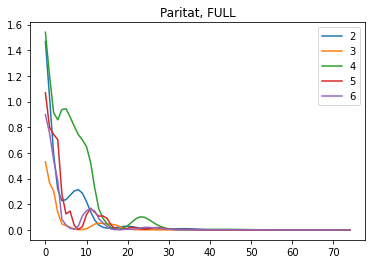

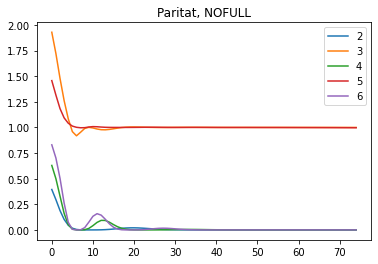

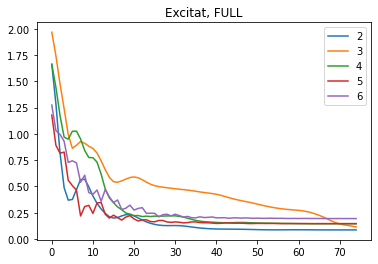

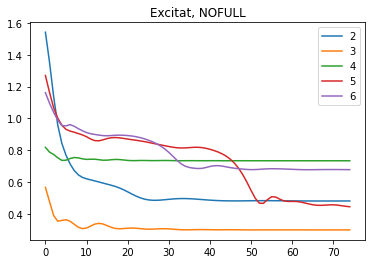

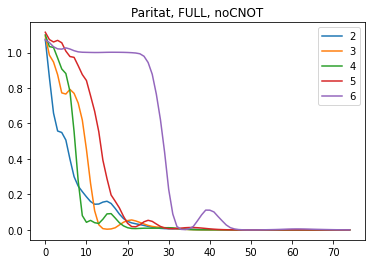

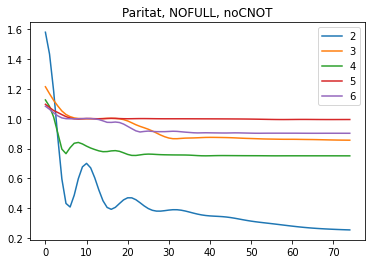

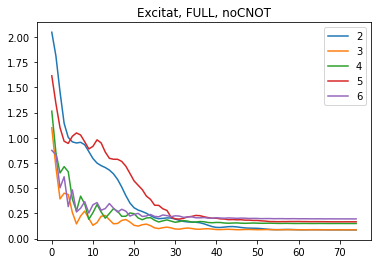

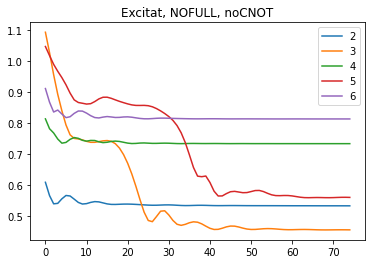

In [581]:
N=6

plt.title("Paritat, FULL")
for n in range(1+1, N+1):
    plt.plot(lossp[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Paritat, NOFULL")
for n in range(1+1, N+1):
    plt.plot(losspF[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Excitat, FULL")
for n in range(1+1, N+1):
    plt.plot(_loss[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Excitat, NOFULL")
for n in range(1+1, N+1):
    plt.plot(lossF[n-1], label=str(n))
plt.legend()
plt.show()





plt.title("Paritat, FULL, noCNOT")
for n in range(1+1, N+1):
    plt.plot(lossp_[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Paritat, NOFULL, noCNOT")
for n in range(1+1, N+1):
    plt.plot(losspF_[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Excitat, FULL, noCNOT")
for n in range(1+1, N+1):
    plt.plot(loss_[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Excitat, NOFULL, noCNOT")
for n in range(1+1, N+1):
    plt.plot(lossF_[n-1], label=str(n))
plt.legend()
plt.show()

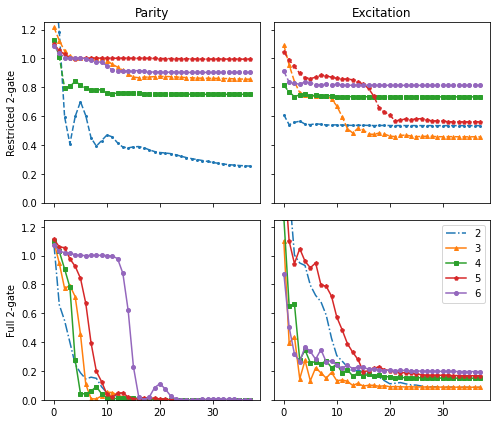

In [675]:
styles = ['.', '^', 's', 'p', 'o']


fig, axs = plt.subplots(2, 2, sharex=True, figsize=(7,6))

axs[1,0].set_ylim(0, 1.25)
axs[1,1].set_ylim(0, 1.25)
axs[0,0].set_ylim(0, 1.25)
axs[0,1].set_ylim(0, 1.25)

#plt.title("Paritat, FULL, noCNOT")
for n in range(1+1, N+1):
    axs[1,0].plot(lossp_[n-1][::2], '-'+ styles[n-2], label="", markersize=4)#str(n))

#plt.title("Paritat, NOFULL, noCNOT")

axs[0,0].set_title("Parity")
axs[0,0].set_ylabel("Restricted 2-gate")

axs[1,0].set_ylabel("Full 2-gate")

for n in range(1+1, N+1):
    axs[0,0].plot(losspF_[n-1][::2], '--'+ styles[n-2], label="", markersize=4)#)str(n))

#plt.title("Excitat, FULL, noCNOT")
for n in range(1+1, N+1):
    axs[1,1].plot(loss_[n-1][::2], '-'+ styles[n-2], label=str(n), markersize=4)

#plt.title("Excitat, NOFULL, noCNOT")
axs[0,1].set_title("Excitation")
for n in range(1+1, N+1):
    axs[0,1].plot(lossF_[n-1][::2], '--'+ styles[n-2], label="", markersize=4)#str(n))
axs[1,1].legend()

#plt.tight_layout()
for ax in fig.get_axes():
    ax.label_outer()
    
plt.tight_layout()
    
plt.savefig('nqubits.pdf')
plt.show()

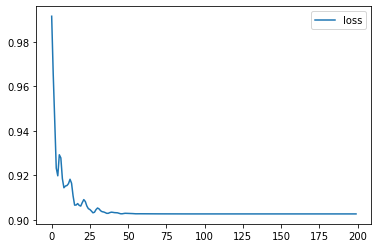

In [246]:
"""print(model(train_excitations))
print(train_labels)

print(loss_fn(train_labels, tf.squeeze(model(train_excitations))))"""

plt.plot(loss_list, label="loss")
plt.legend()

In [184]:
temp = model.trainable_weights
temp

[<tf.Variable 'parameters:0' shape=(6,) dtype=float32, numpy=
array([ 0.95383805,  3.445206  ,  3.0512972 , -0.3224178 ,  2.4567301 ,
       -0.28668672], dtype=float32)>]


[<tf.Variable 'parameters:0' shape=(6,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [165]:
model.set_weights(np.array([[0.0,0,0]]))
print(model.trainable_weights)


pred = model(inputs)
print(train_labels)
print(pred)

loss_value = tf.math.reduce_mean(loss_fn(train_labels, tf.squeeze(pred)))
print(loss_value)

SVGCircuit(quantum_model_circuit)

ValueError: Layer model_18 weight shape (6,) is not compatible with provided weight shape (3,).

In [142]:
inputs, labels = generate_data_p(qubits)

"""for el in inputs:
    print(el)"""
    
    
"""print()
print(el)"""

mod = tfq.layers.AddCircuit()(quantum_model_circuit, prepend=inputs[1])

print(tfq.from_tensor(mod)[0])

00

01
(0, 1): ───X───
10
(0, 0): ───X───
11
(0, 0): ───X───

(0, 1): ───X───


InvalidArgumentError: Exception encountered when calling layer "add_circuit_54" (type AddCircuit).

programs must be rank 1. Got rank 0. [Op:TfqAppendCircuit]

Call arguments received:
  • inputs=cirq.Circuit([
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 0), cirq.GridQubit(-1, -1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(-1, -1)),
    ),
])
  • append=None
  • prepend=tf.Tensor(shape=(), dtype=string)

In [129]:
model.predict(train_excitations)

array([[ 1.],
       [ 1.],
       [-1.],
       [-1.]], dtype=float32)

## Results
After comparing and making sure we obtain the same as using qibo, everything being well controlled, we start analyzing more into detail the problems themselves rather than the implementation